In [7]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import talib
import pynance as pn
from datetime import datetime, timedelta
import sys
from pathlib import Path

# Add project root to path for importing our module
sys.path.append(str(Path.cwd().parent))
from src.quantitative_analysis import QuantitativeAnalyzer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Configure plotting
sns.set_theme()  # Use seaborn's default theme
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Initialize our analyzer
analyzer = QuantitativeAnalyzer()

# Load the news data to get stock symbols
print("Loading news data...")
news_df = pd.read_csv('../data/raw/raw_analyst_ratings.csv')

# Get unique stock symbols and their frequency
stock_counts = news_df['stock'].value_counts()
print("\nTop 10 most mentioned stocks:")
print(stock_counts.head(10))


Loading news data...

Top 10 most mentioned stocks:
stock
MRK     3333
MS      3238
NVDA    3146
MU      3142
QQQ     3106
NFLX    3028
M       3025
EBAY    3018
GILD    2968
VZ      2966
Name: count, dtype: int64


In [8]:
# Function to fetch stock data
def fetch_stock_data(symbol, start_date, end_date):
    """Fetch stock data using yfinance."""
    try:
        stock = yf.Ticker(symbol)
        df = stock.history(start=start_date, end=end_date)
        if len(df) > 0:
            return df
        else:
            print(f"No data found for {symbol}")
            return None
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")
        return None

# Check the date format first
print("Sample dates from the dataset:")
print(news_df['date'].head())

# Parse dates and convert to UTC
news_df['date'] = pd.to_datetime(news_df['date'], format='mixed', utc=True)

# Get the date range
start_date = news_df['date'].min().tz_convert('UTC')
end_date = news_df['date'].max().tz_convert('UTC')

print(f"\nData range: {start_date} to {end_date}")

# Convert dates to string format for yfinance (which expects YYYY-MM-DD)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Get top 5 most mentioned stocks
top_stocks = stock_counts.head(5).index.tolist()

# Fetch data for top stocks
stock_data = {}
for symbol in top_stocks:
    data = fetch_stock_data(symbol, start_date_str, end_date_str)
    if data is not None:
        stock_data[symbol] = data
        print(f"Loaded data for {symbol}: {len(data)} records")


Sample dates from the dataset:
0    2020-06-05 10:30:54-04:00
1    2020-06-03 10:45:20-04:00
2    2020-05-26 04:30:07-04:00
3    2020-05-22 12:45:06-04:00
4    2020-05-22 11:38:59-04:00
Name: date, dtype: object

Data range: 2009-02-14 00:00:00+00:00 to 2020-06-11 21:12:35+00:00
Loaded data for MRK: 2849 records
Loaded data for MS: 2849 records
Loaded data for NVDA: 2849 records
Loaded data for MU: 2849 records
Loaded data for QQQ: 2849 records


In [9]:
# Calculate indicators for each stock
analyzed_data = {}
for symbol, data in stock_data.items():
    # Calculate technical indicators
    df_with_indicators = analyzer.calculate_technical_indicators(data)

    # Calculate financial metrics
    metrics = analyzer.calculate_financial_metrics(data)

    # Analyze volume profile
    volume_analysis = analyzer.analyze_volume_profile(data)

    # Find support and resistance levels
    support, resistance = analyzer.identify_support_resistance(data)

    analyzed_data[symbol] = {
        'data': df_with_indicators,
        'metrics': metrics,
        'volume_analysis': volume_analysis,
        'support_levels': support,
        'resistance_levels': resistance
    }

    print(f"\nAnalysis completed for {symbol}")
    print("\nFinancial Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nVolume Analysis:")
    for metric, value in volume_analysis.items():
        if metric != 'high_volume_days':
            print(f"{metric}: {value:.4f}")
    print(f"Number of high volume days: {len(volume_analysis['high_volume_days'])}")

    print("\nSupport and Resistance Levels:")
    print(f"Found {len(support)} support levels and {len(resistance)} resistance levels")



Analysis completed for MRK

Financial Metrics:
daily_returns_mean: 0.0006
daily_returns_std: 0.0140
annualized_volatility: 0.2226
sharpe_ratio: 0.6911
max_drawdown: -0.2726

Volume Analysis:
avg_volume: 13513086.5430
volume_trend: -3304.1669
volume_price_corr: -0.3772
Number of high volume days: 109

Support and Resistance Levels:
Found 51 support levels and 48 resistance levels

Analysis completed for MS

Financial Metrics:
daily_returns_mean: 0.0007
daily_returns_std: 0.0249
annualized_volatility: 0.3960
sharpe_ratio: 0.4373
max_drawdown: -0.6460

Volume Analysis:
avg_volume: 15856646.1565
volume_trend: -5959.8338
volume_price_corr: -0.4979
Number of high volume days: 129

Support and Resistance Levels:
Found 49 support levels and 48 resistance levels

Analysis completed for NVDA

Financial Metrics:
daily_returns_mean: 0.0018
daily_returns_std: 0.0274
annualized_volatility: 0.4352
sharpe_ratio: 1.0199
max_drawdown: -0.5604

Volume Analysis:
avg_volume: 541768289.2243
volume_trend: -

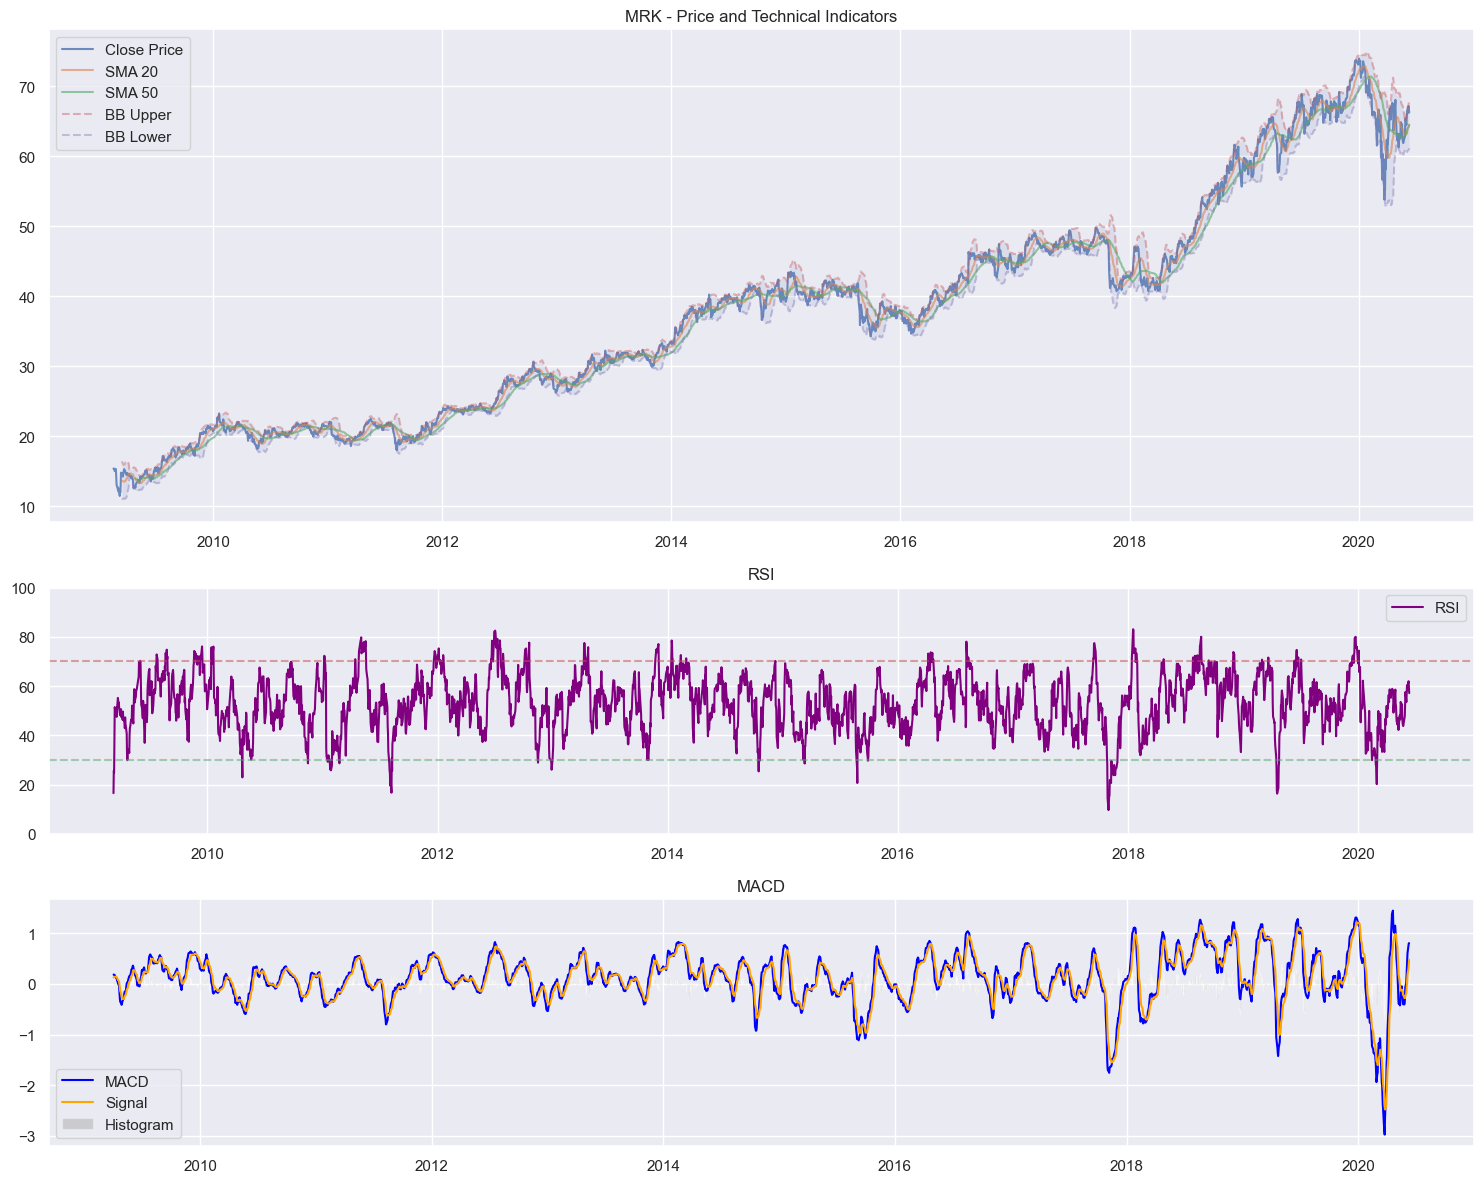

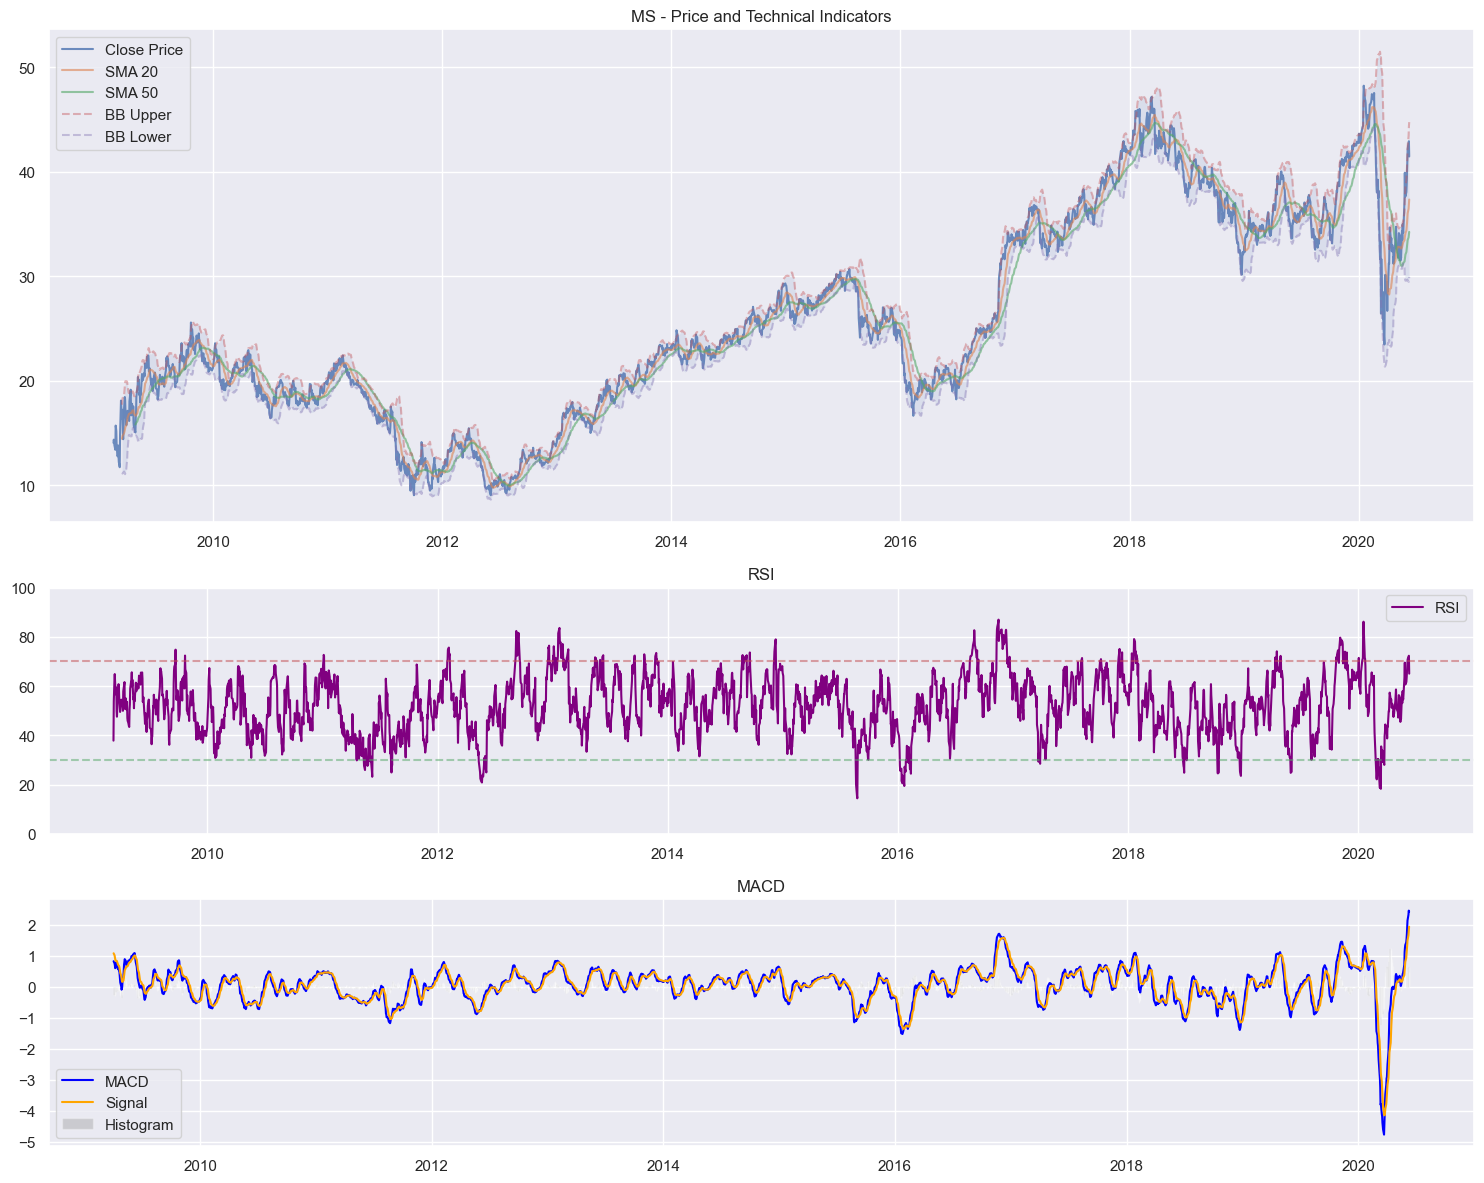

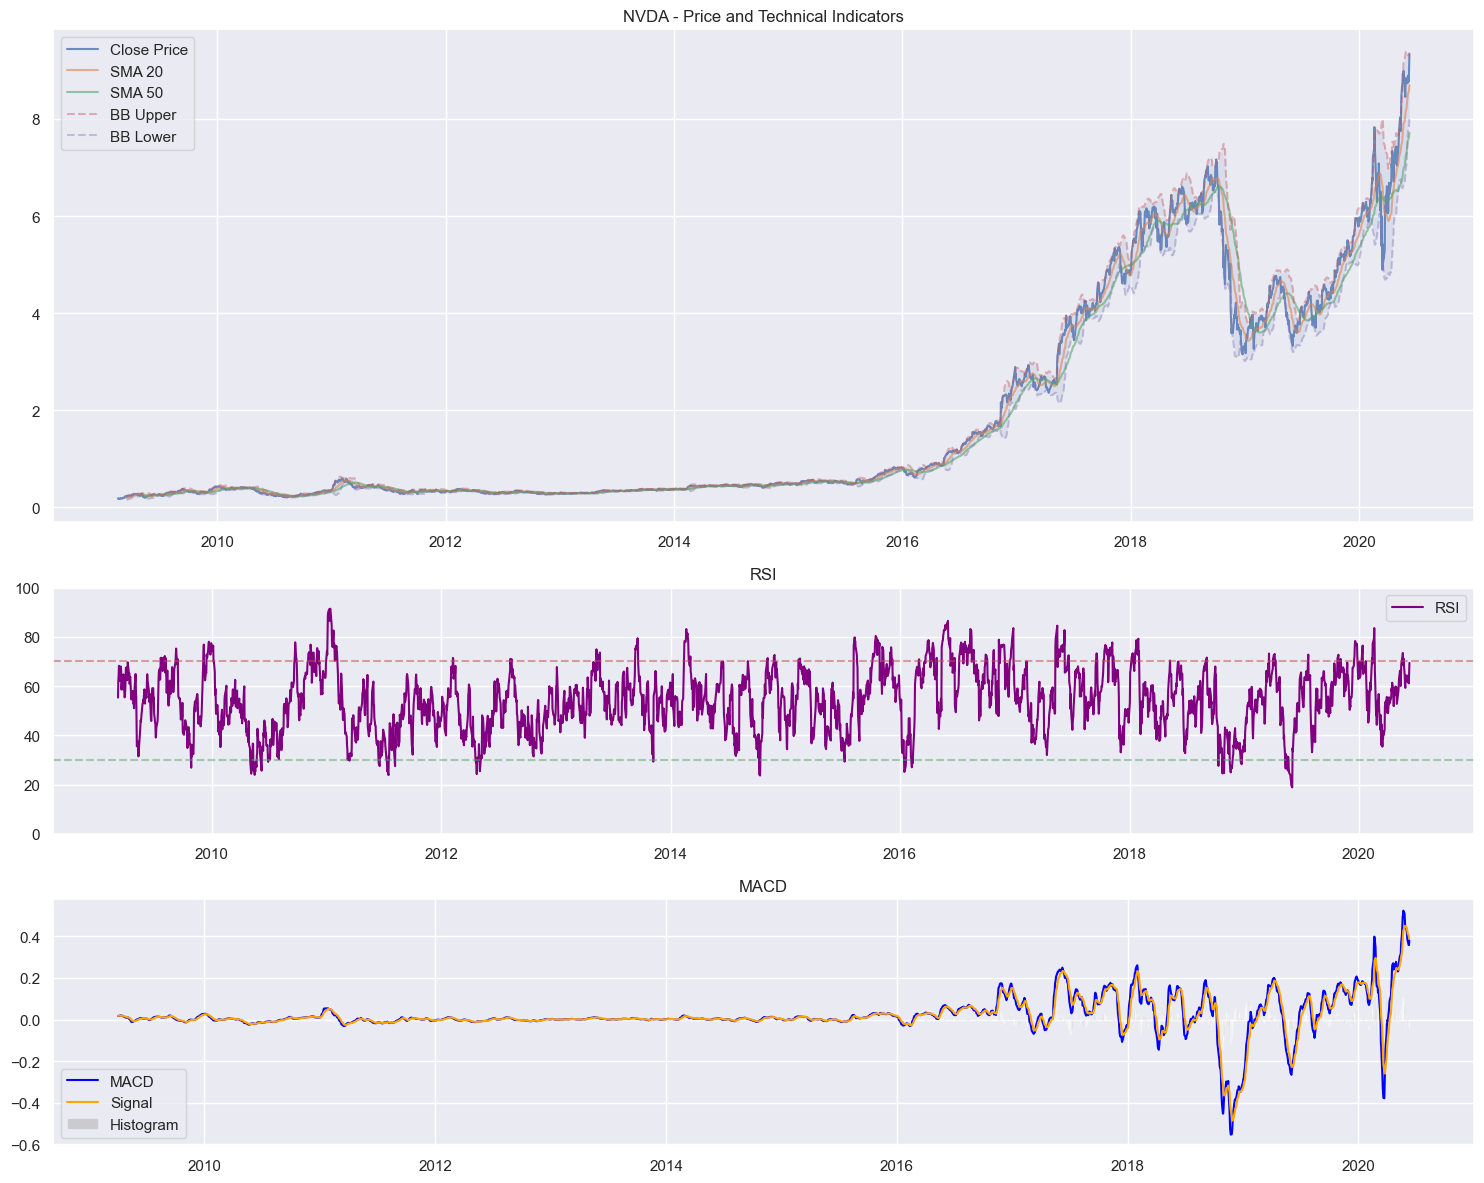

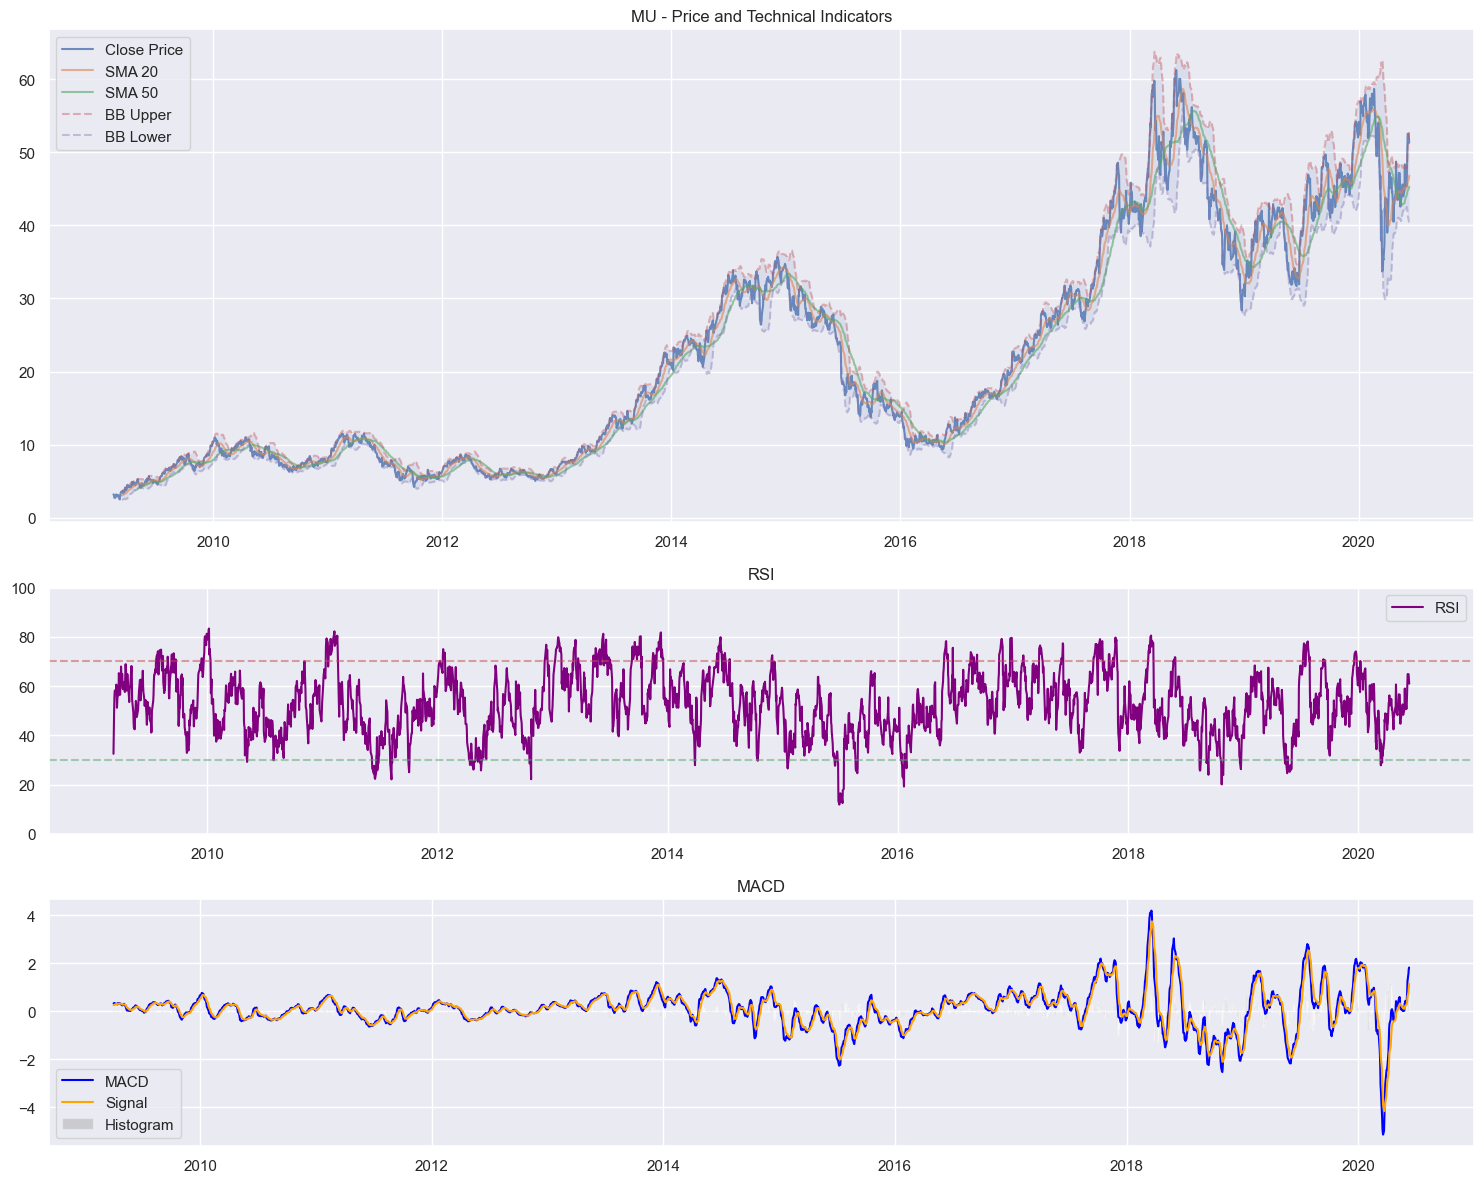

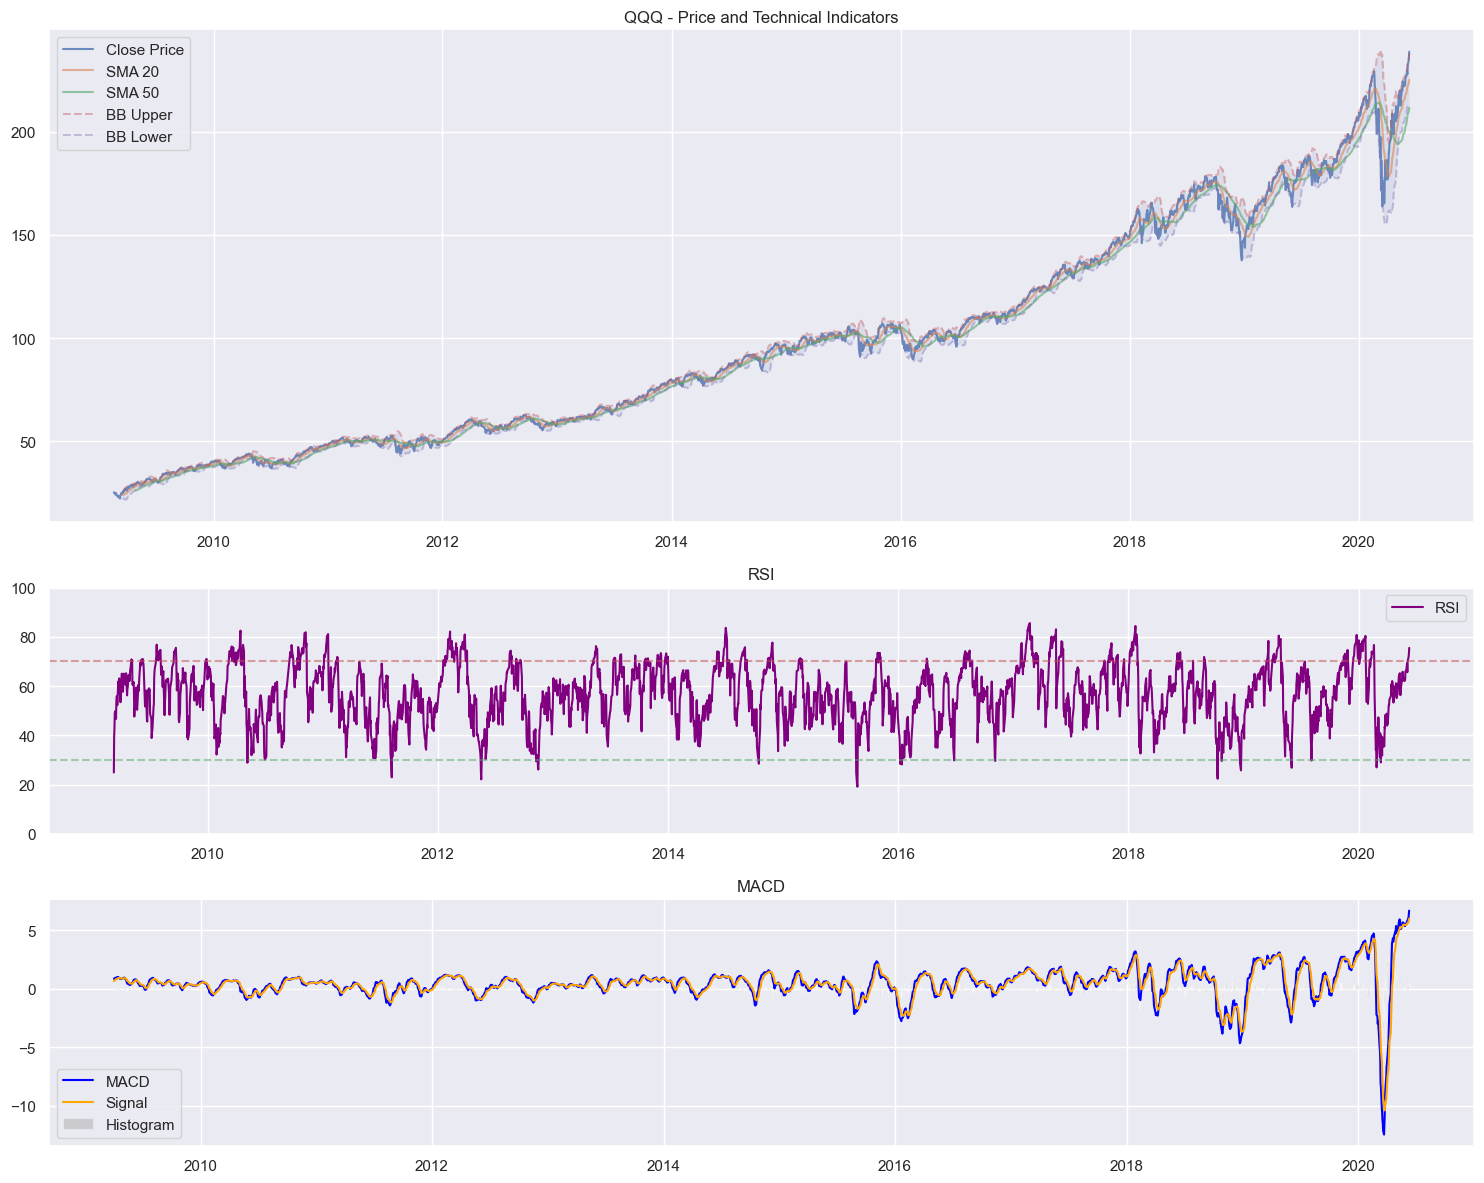

In [10]:
def plot_technical_analysis(symbol, data):
    """Create technical analysis plots for a stock."""
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])

    # Price and Moving Averages
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(data.index, data['Close'], label='Close Price', alpha=0.8)
    ax1.plot(data.index, data['SMA_20'], label='SMA 20', alpha=0.6)
    ax1.plot(data.index, data['SMA_50'], label='SMA 50', alpha=0.6)
    ax1.plot(data.index, data['BB_Upper'], '--', label='BB Upper', alpha=0.4)
    ax1.plot(data.index, data['BB_Lower'], '--', label='BB Lower', alpha=0.4)
    ax1.fill_between(data.index, data['BB_Upper'], data['BB_Lower'], alpha=0.1)
    ax1.set_title(f'{symbol} - Price and Technical Indicators')
    ax1.legend()
    ax1.grid(True)

    # RSI
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(data.index, data['RSI'], label='RSI', color='purple')
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax2.set_ylim(0, 100)
    ax2.set_title('RSI')
    ax2.legend()
    ax2.grid(True)

    # MACD
    ax3 = fig.add_subplot(gs[2])
    ax3.plot(data.index, data['MACD'], label='MACD', color='blue')
    ax3.plot(data.index, data['MACD_Signal'], label='Signal', color='orange')
    ax3.bar(data.index, data['MACD_Hist'], label='Histogram', alpha=0.3, color='gray')
    ax3.set_title('MACD')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# Plot technical analysis for each stock
for symbol, analysis in analyzed_data.items():
    plot_technical_analysis(symbol, analysis['data'])


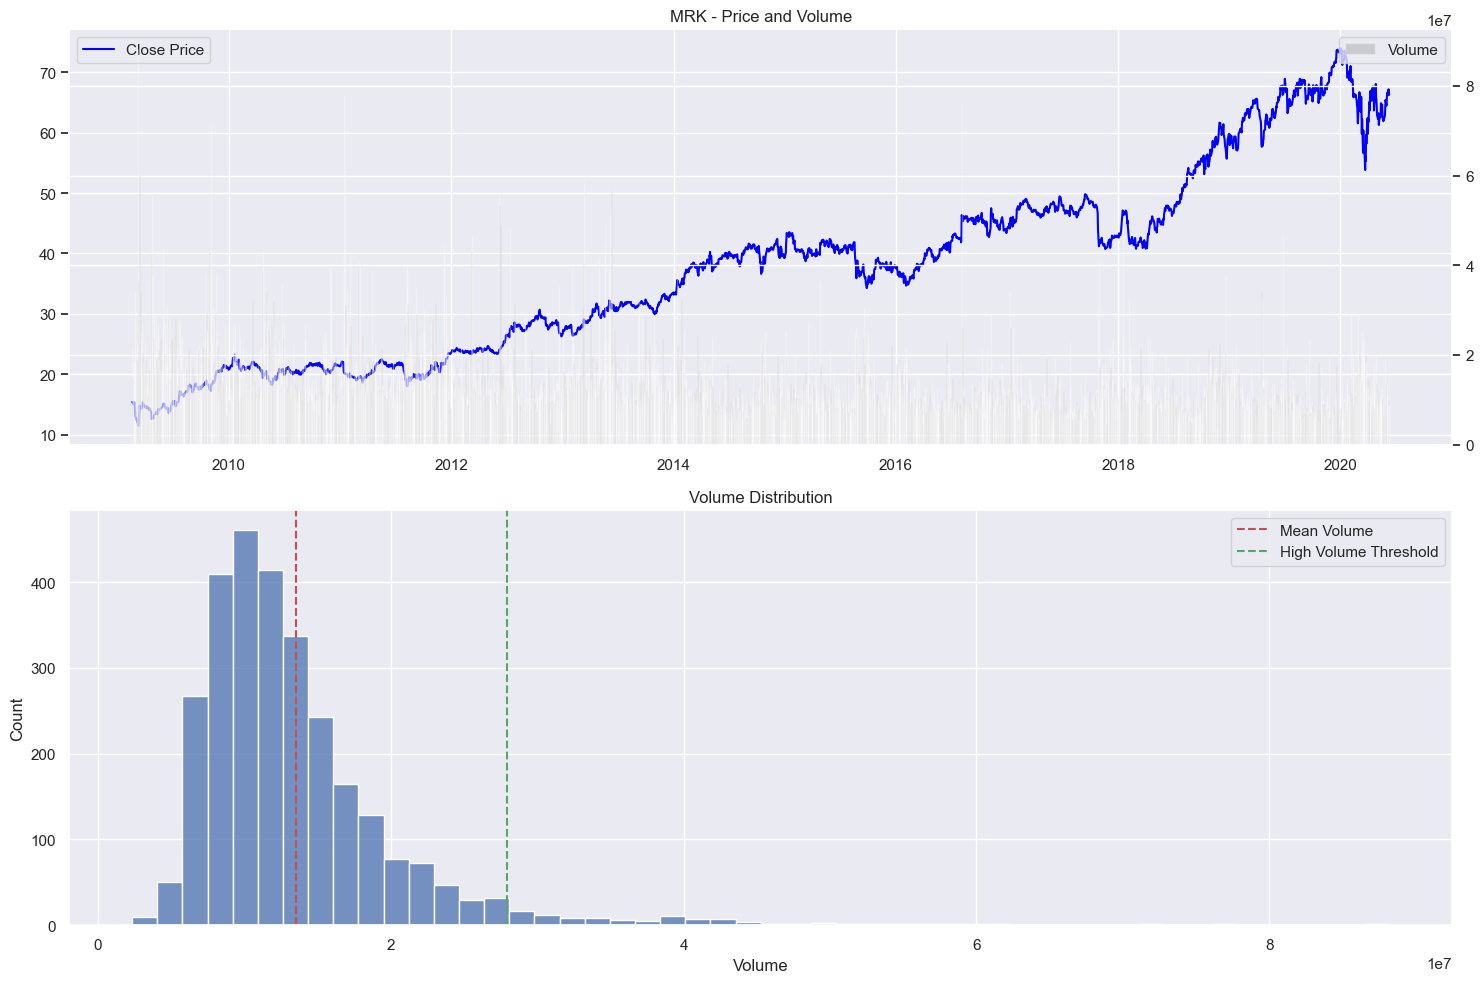

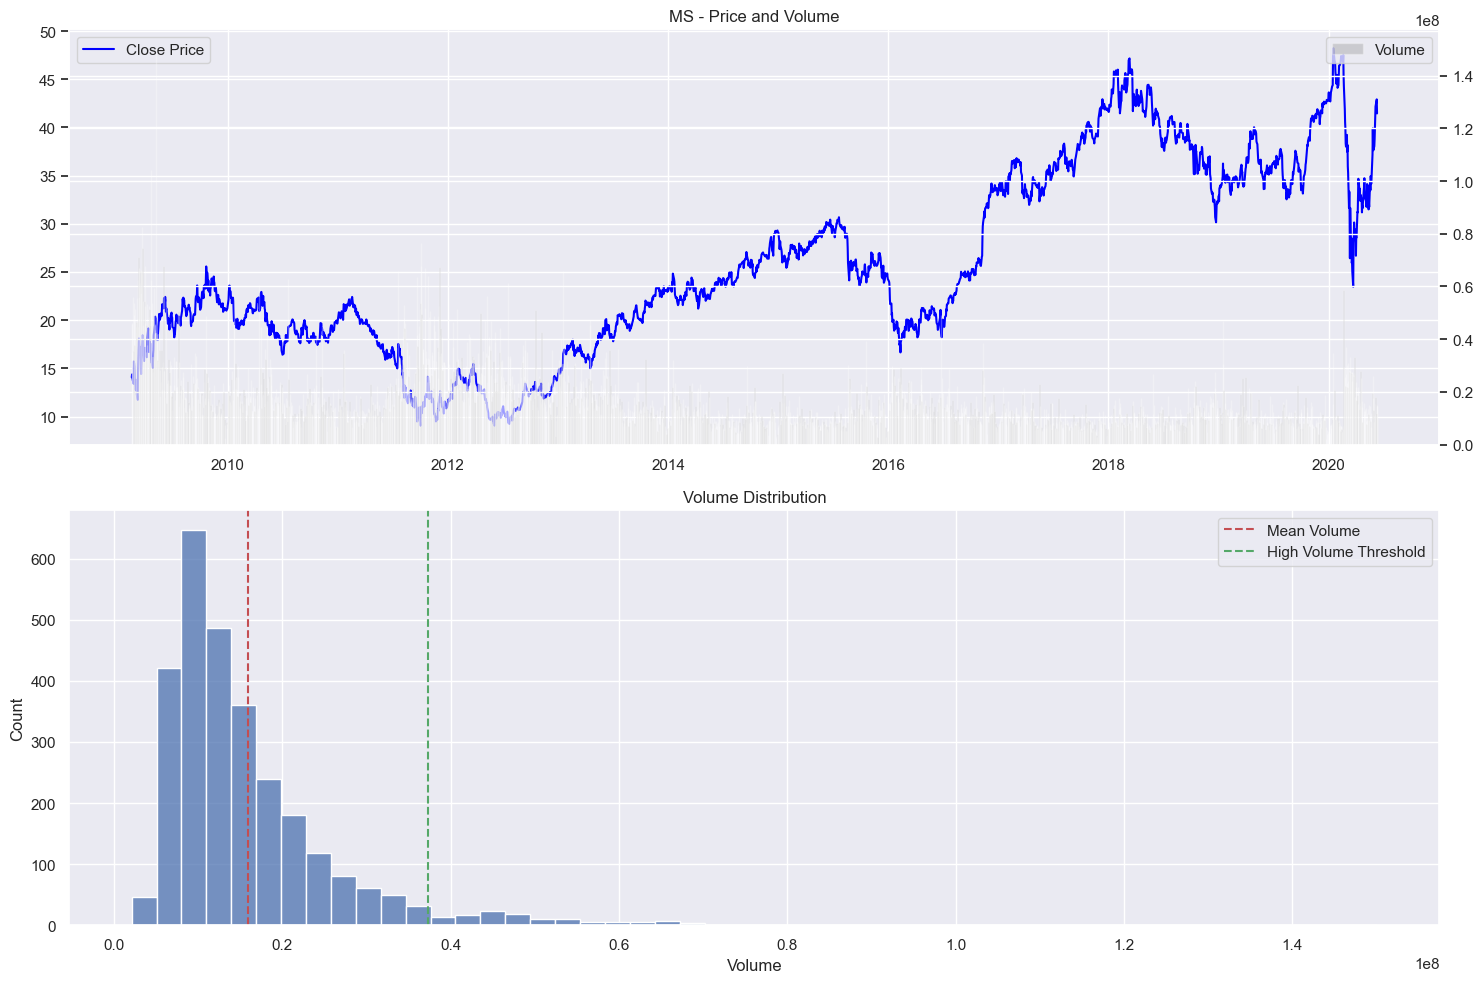

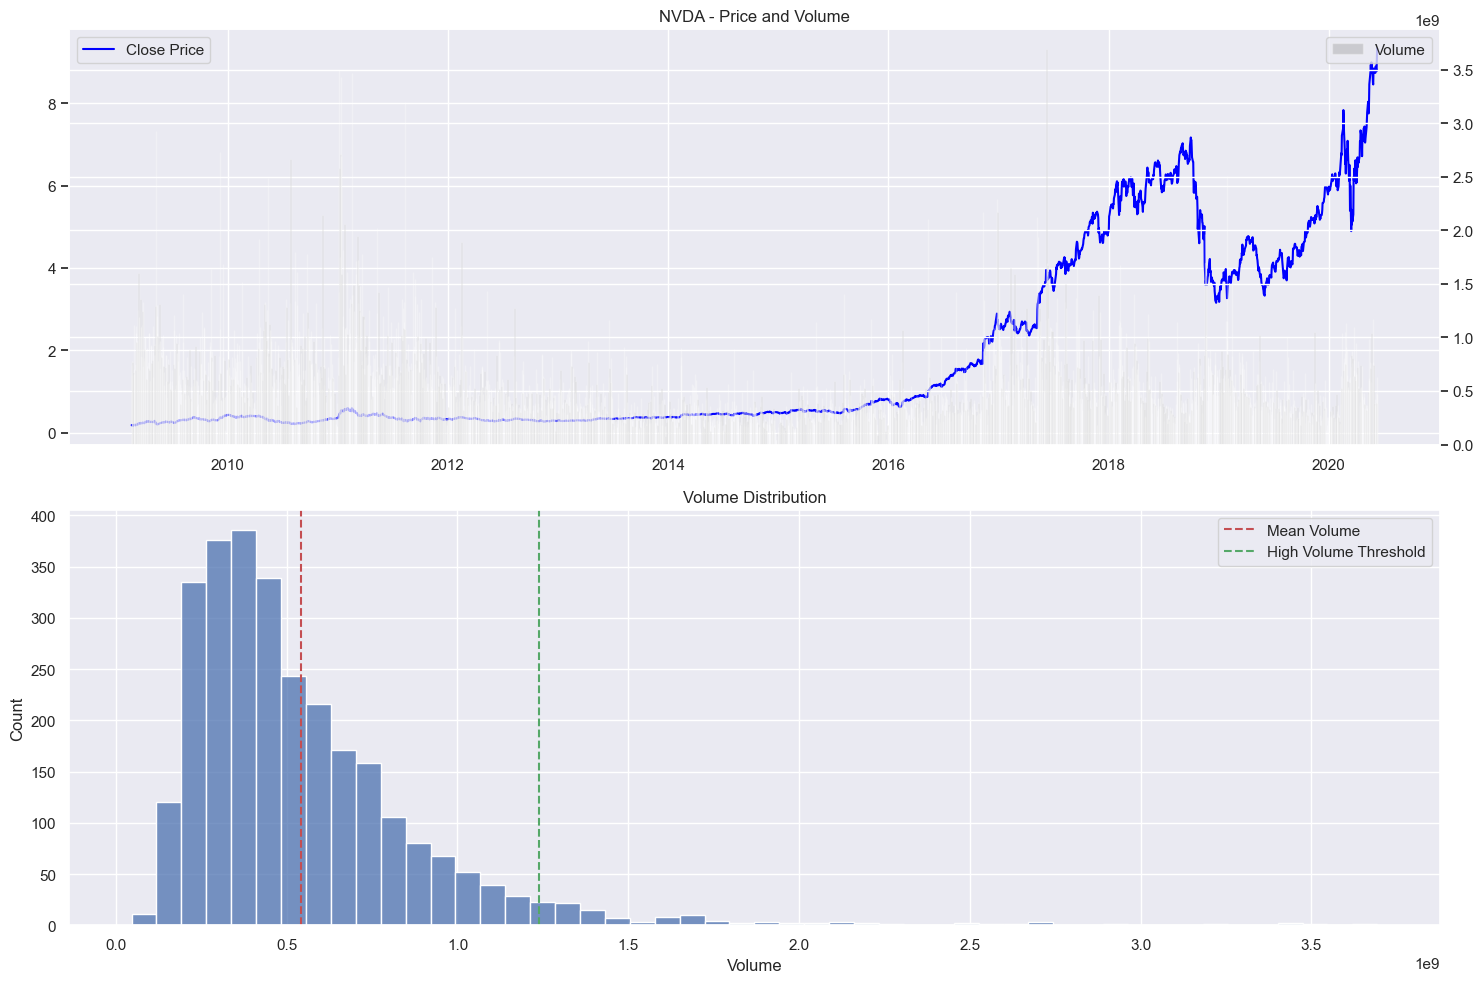

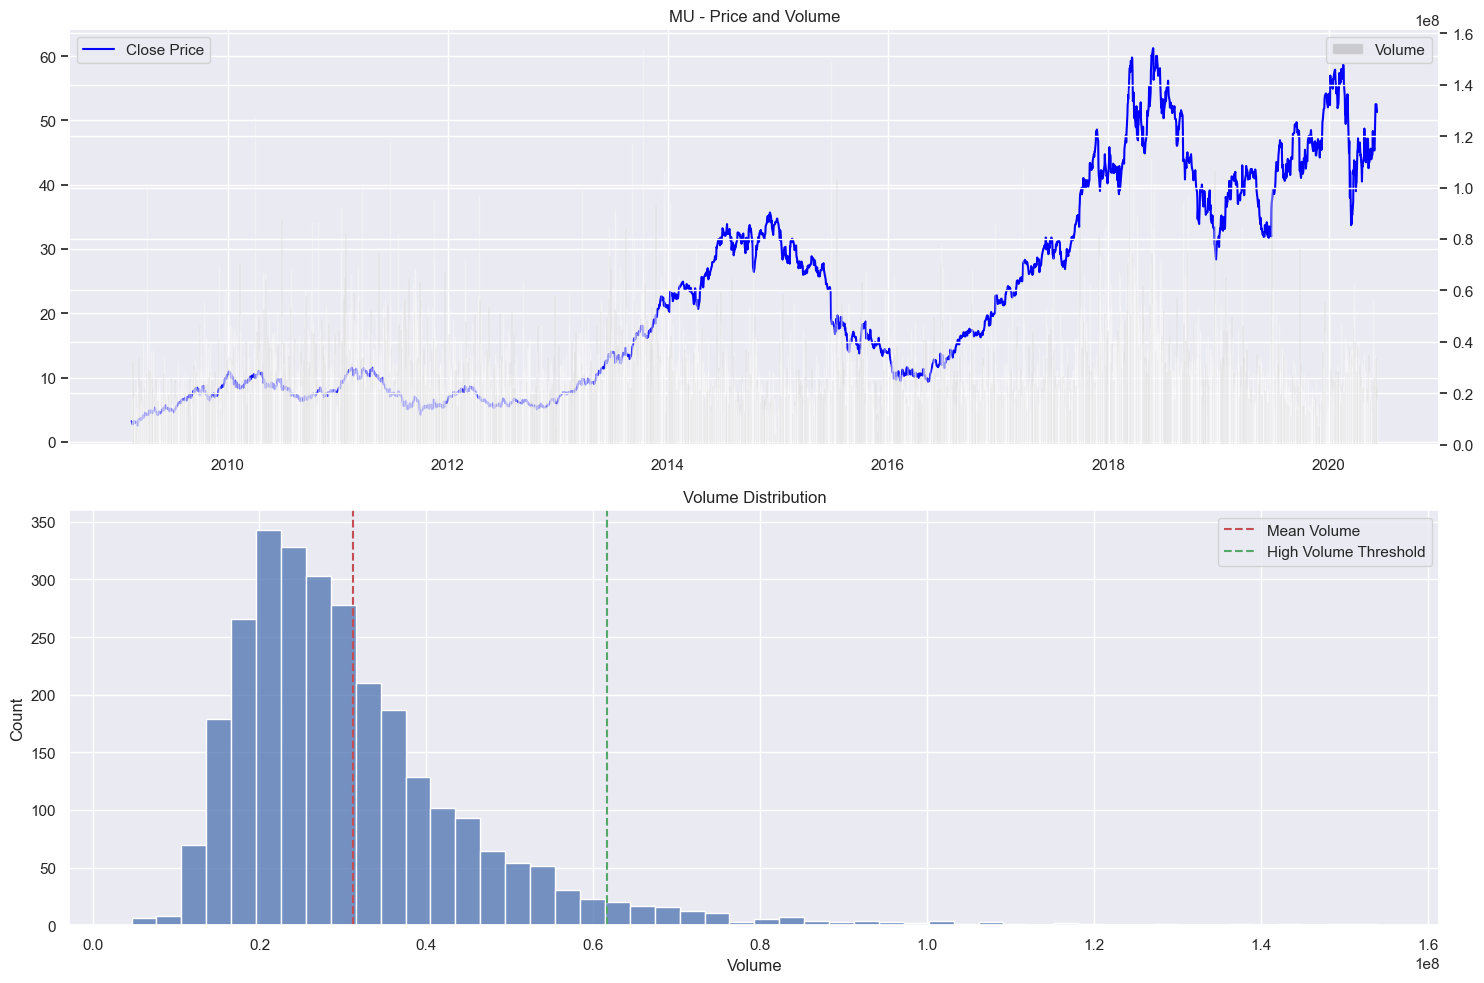

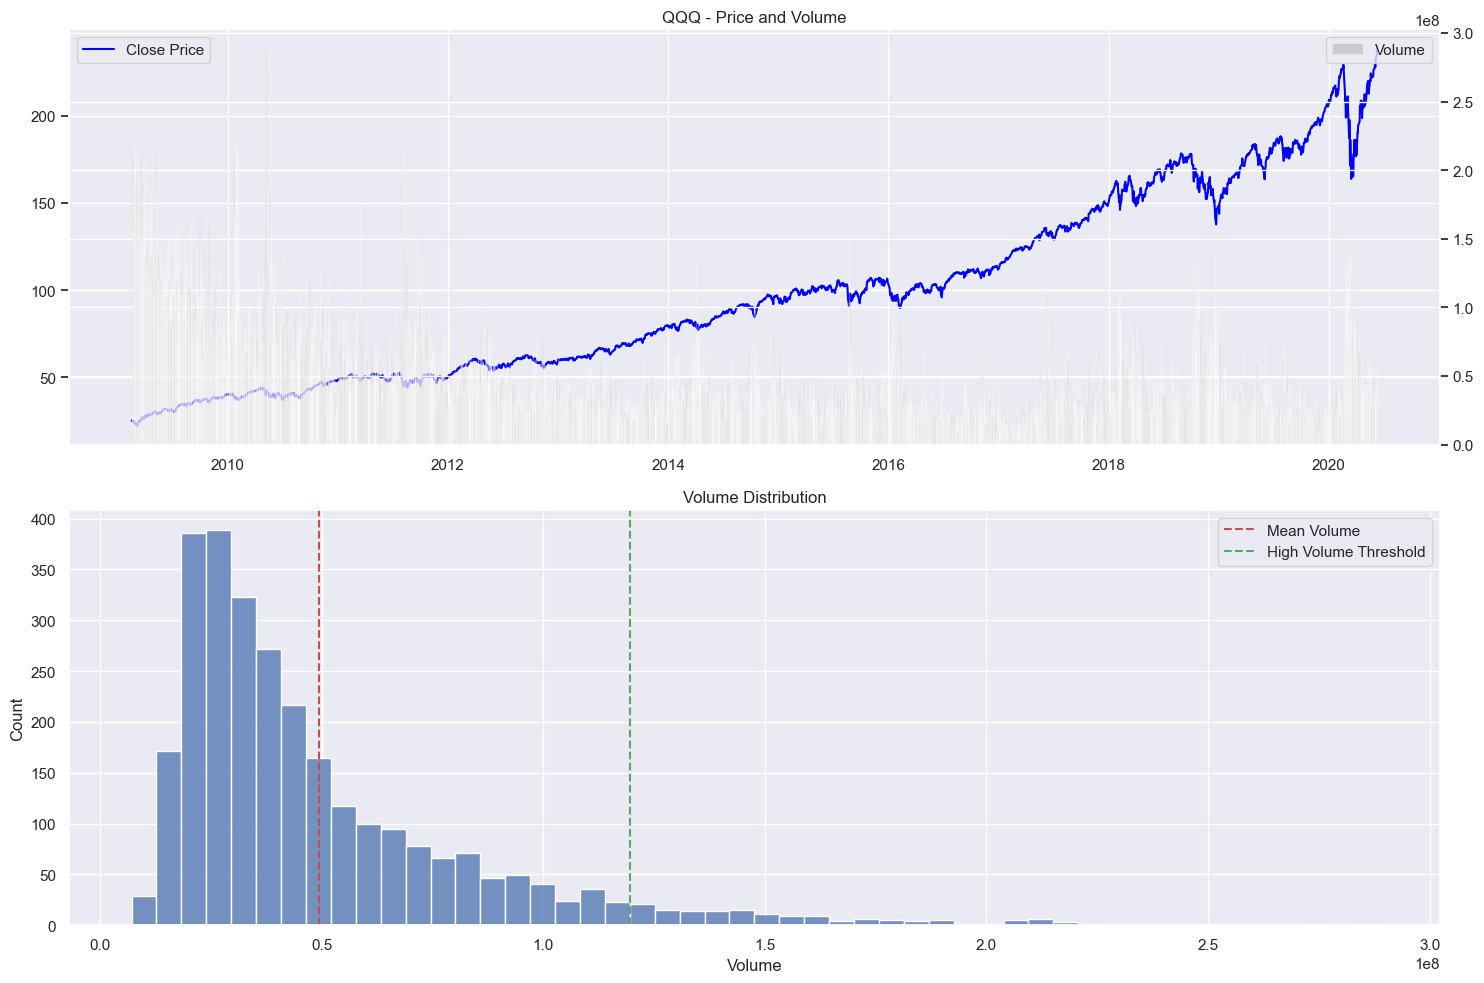

In [11]:
def plot_volume_analysis(symbol, data):
    """Create volume analysis plots for a stock."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Price and Volume
    ax1.plot(data.index, data['Close'], label='Close Price', color='blue')
    ax1_twin = ax1.twinx()
    ax1_twin.bar(data.index, data['Volume'], alpha=0.3, color='gray', label='Volume')
    ax1.set_title(f'{symbol} - Price and Volume')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True)

    # Volume Distribution
    sns.histplot(data=data, x='Volume', bins=50, ax=ax2)
    ax2.axvline(data['Volume'].mean(), color='r', linestyle='--', label='Mean Volume')
    ax2.axvline(data['Volume'].mean() + 2*data['Volume'].std(), color='g', linestyle='--',
                label='High Volume Threshold')
    ax2.set_title('Volume Distribution')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot volume analysis for each stock
for symbol, analysis in analyzed_data.items():
    plot_volume_analysis(symbol, analysis['data'])


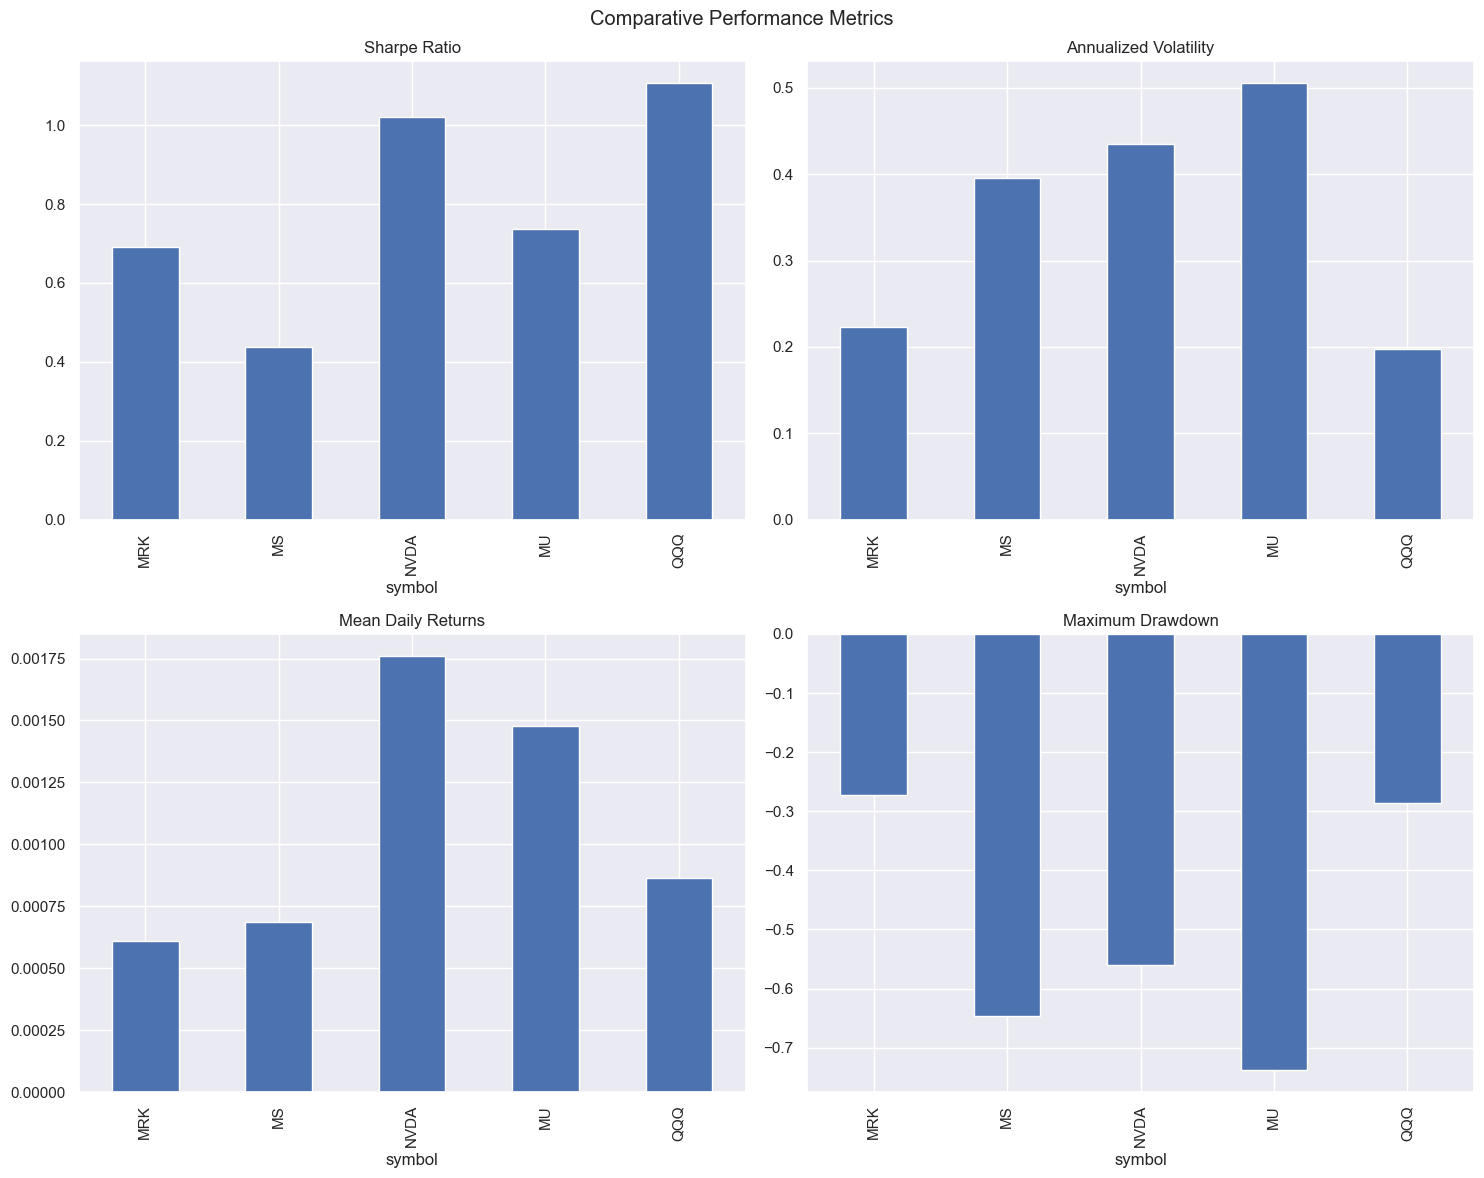


Comparative Metrics:
        daily_returns_mean  daily_returns_std  annualized_volatility  \
symbol                                                                 
MRK                 0.0006             0.0140                 0.2226   
MS                  0.0007             0.0249                 0.3960   
NVDA                0.0018             0.0274                 0.4352   
MU                  0.0015             0.0318                 0.5055   
QQQ                 0.0009             0.0124                 0.1971   

        sharpe_ratio  max_drawdown  
symbol                              
MRK           0.6911       -0.2726  
MS            0.4373       -0.6460  
NVDA          1.0199       -0.5604  
MU            0.7366       -0.7380  
QQQ           1.1063       -0.2856  


In [12]:
# Create comparative metrics dataframe
metrics_data = []
for symbol, analysis in analyzed_data.items():
    metrics = analysis['metrics']
    metrics['symbol'] = symbol
    metrics_data.append(metrics)

metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index('symbol', inplace=True)

# Plot comparative metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparative Performance Metrics')

# Sharpe Ratio
metrics_df['sharpe_ratio'].plot(kind='bar', ax=axes[0,0], title='Sharpe Ratio')
axes[0,0].grid(True)

# Volatility
metrics_df['annualized_volatility'].plot(kind='bar', ax=axes[0,1], title='Annualized Volatility')
axes[0,1].grid(True)

# Mean Returns
metrics_df['daily_returns_mean'].plot(kind='bar', ax=axes[1,0], title='Mean Daily Returns')
axes[1,0].grid(True)

# Max Drawdown
metrics_df['max_drawdown'].plot(kind='bar', ax=axes[1,1], title='Maximum Drawdown')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

# Display metrics table
print("\nComparative Metrics:")
print(metrics_df.round(4))
